# Data sonification with Python

## Instructors

- Walt Gurley

## Workshop Description
Data visualization is the process of using graphical elements to represent data. This workshop introduces the concept of data sonification, using characteristics of sound to represent information. Sonification can provide an alternate mode for communicating data with implications for accessibility, engagement, and discovery. Participants in this workshop will get an overview of sonification techniques and tools and learn basic processes for mapping data to sound using the Python programming language.

## Notebook setup

This cell loads the necessary libraries and modules. If this notebook is run in Google Colab, it will also install and load extra dependencies to create audio files and play audio files. If this notebook is run on a local machine, the process of creating and playing audio is simplified and does not require the creation of audio files.

Libraries imported into this notebook:
- [music21](https://web.mit.edu/music21/) - toolkit for computer-aided musicology
- [pandas](https://pandas.pydata.org/) - a data analysis and manipulation tool
- [NumPy](https://numpy.org/) - a library supporting numerical analysis
- [matplotlib]() - a plotting library
- [midi2audio](https://pypi.org/project/midi2audio/) - a tool for synthesizing or playing MIDI audio

Additional dependencies:
- [Fluidsynth](http://www.fluidsynth.org/) - a synthesizer for processing MIDI files
- [IPython Audio controls](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html?highlight=audio#IPython.display.Audio) - a tool for playing audio and generating audio controls in a Jupyter notebook 

In [1]:
# Test if this notebook is running in Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print("I am in Colab: " + str(IN_COLAB))

# If running in Colab install additional dependencies to create audio files from
# MIDI files
if IN_COLAB:
  # Install synthesizer to provide sound fonts (i.e., instruments)
  !apt install fluidsynth
  # Copy the soundfonts file to our session storage space
  !cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
  # Install and load midi2audio module to convert MIDI files to audio files
  !pip install midi2audio
  from midi2audio import FluidSynth

# Load modules from the music21 library for sonifying data
from music21 import instrument, note, scale, stream, midi, tempo

# Load data processing and visualization libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

# Load the Audio display tool to play and control audio
from IPython.display import Audio

I am in Colab: True
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 29 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8,596 B]
Get:5 http://archive.ubuntu.c

## A brief overview of audio properties and sonification

Sound travels through air like a wave as particles are compressed together and then stretched apart. By measuring how these particles change we can represent sound as a series of waves called a waveform.

An audio waveform has two basic properties, **amplitude** and **wavelength**. Amplitude is measured as the magnitude of displacement of a particle from its original position and can be thought of as loudness. Wavelength is used to measure frequency. Frequency is a measure of how many times the waveform repeats over time. Frequency is directly related to pitch, lower frequencies have a lower pitch and higher frequencies a higher pitch. Humans have a general hearing frequency range of 20 Hz to 20,000 Hz (Hz = one cycle per second).

Here is a wonderful [interactive guide to audio waveforms](https://pudding.cool/2018/02/waveforms/) by Josh Comeau.

![An image representing a sound wave traveling through the air and as a waveform.](https://github.com/WaltGurley/rem-rem-cur/blob/gh-pages/MicIn/particleSound.png?raw=true "As a sound wave travels through the air particles are compressed and stretched apart. This can be modeled as a waveform")

Beyond the basic properties of sound waves we can also consider the audio properties of timbre (the perceived quality of a sound, e.g., how a guitar sounds different than a trumpet), tempo (the speed at which a collection of sounds are played, e.g., beats per minute), and spatial positioning (where a sound is coming from in space, e.g., panning left or right in stereo sound).

Just as we may map a data value to color, position, or size on a graph, we can use these properties of sound to represent data sonically. Sonification has the ability to represent data in a way that complements visualization and has valid application with regard to accessibility, engagement, and discovery:

- Accessibility: [SAS Graphics Accelerator](https://support.sas.com/software/products/graphics-accelerator/samples/index.html)

- Engagement: [Sounds from Around the Milky Way](https://www.nasa.gov/mission_pages/chandra/news/data-sonification-sounds-from-around-the-milky-way.html)

- Discovery: [Sonification of Cyclone Sidr](https://youtu.be/RRluA1r3rTk)


## Load and observe/clean the dataset

We will be working with a dataset consisting of monthly atmospheric CO2 values measured at Mauna Loa Observatory, Hawaii from the Scripps CO2 program website (visit the [Scripps CO2 program website](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html) for more information about the dataset we are using).

We load the raw dataset directly from the Scripps website using the pandas method `read_csv()`. The raw data file requires some intial parsing and manipulation using arguments passed into `read_csv()`, such as identifying the starting row of the data (using the keyword argument `header=56`), filtering only the columns of data of interest (using the keyword argument `usecols=[0, 1, 2, 4, 5]`, and parsing dates (using the keyword argument `parse_dates=[2]` and the `date_parser` function). Comments are included in the code below to describe each argument.

In [2]:
# Read and format the csv file located at the provided URL into a Pandas DataFrame
co2_raw = pd.read_csv(
  # The URL of the csv file
  "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv",
  # The row position of the column headers for the dataset
  header=56,
  # Create new column header names to rename given headers
  names=["year", "month", "date", "CO2ppm", "season_adj"],
  # Only take the specified columns from the csv file
  usecols=[0,1,2,4,5],
  # Parse dates from the data given in column 2
  parse_dates=[2],
  # How to parse the date values
  date_parser=lambda x: pd.to_datetime(int(x), unit='D', origin=pd.Timestamp('01-01-1900')),
  # Set the column index of the DataFrame
  index_col=2
)

# Print the data
co2_raw

year  month  CO2ppm  season_adj
date                                       
1958-01-17  1958      1  -99.99      -99.99
1958-02-17  1958      2  -99.99      -99.99
1958-03-17  1958      3  315.70      314.43
1958-04-17  1958      4  317.46      315.16
1958-05-17  1958      5  317.51      314.70
...          ...    ...     ...         ...
2021-08-17  2021      8  -99.99      -99.99
2021-09-17  2021      9  -99.99      -99.99
2021-10-17  2021     10  -99.99      -99.99
2021-11-17  2021     11  -99.99      -99.99
2021-12-17  2021     12  -99.99      -99.99

[768 rows x 4 columns]

In [3]:
# Replace missing values (-99.99) with NaN
co2 = co2_raw.replace(-99.99, np.nan)

# Trim dataset to remove leading and trailing missing CO2 data
co2 = co2.loc[co2["CO2ppm"].first_valid_index():co2["CO2ppm"].last_valid_index()]

# Print the data
co2

year  month  CO2ppm  season_adj
date                                       
1958-03-17  1958      3  315.70      314.43
1958-04-17  1958      4  317.46      315.16
1958-05-17  1958      5  317.51      314.70
1958-06-17  1958      6     NaN         NaN
1958-07-17  1958      7  315.86      315.19
...          ...    ...     ...         ...
2020-10-17  2020     10  411.15      414.78
2020-11-17  2020     11  412.88      415.15
2020-12-17  2020     12  413.89      414.82
2021-01-17  2021      1  415.16      415.11
2021-02-17  2021      2  416.46      415.70

[756 rows x 4 columns]

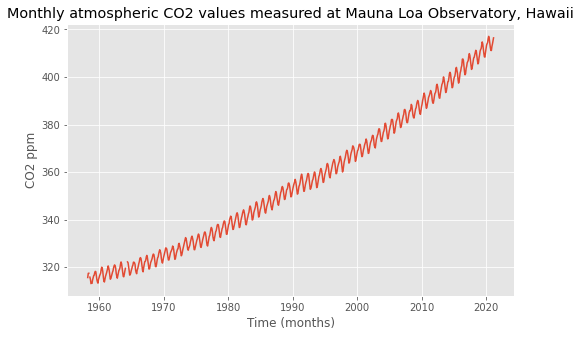

In [4]:
# Configure the plot
plt.figure(figsize=[8, 5])
plt.xlabel("Time (months)")
plt.ylabel("CO2 ppm")
plt.title("Monthly atmospheric CO2 values measured at Mauna Loa Observatory, Hawaii")

# Plot the data
plt.plot(co2["CO2ppm"])

**Question:** What properties of sound could we use to sonify this dataset (e.g., frequency, amplitude, timbre, tempo, and spatial position)?

## Audification
Audification is a type of sonification in which a data series is directly translated into an audio waveform. This sonification process is applied in research ranging from medicine to seismology and astronomy.

Audification is typically suitable for large datasets that have a cyclical component.

Examples:

- [Vibrations of the Sun](https://soundcloud.com/nasa/sun-sonification)
- [Audification of brainwave data](https://youtu.be/y1Nl3De_frM)

### Audification of a sine wave
We will first demonstrate the process of audification by generating a sine wave over time and then converting that data into audio.

When creating audio we need to consider two things, the sample rate and the shape of the sound wave.

In [5]:
# How many times per second (Hz) are we sampling our data?
sample_rate = 44100

# Over how many seconds are we sampling our data?
time = 2

# Generate a series of time samples at a rate of 'sampleRate' Hz over 'time' 
# seconds (44100 Hz * 2 seconds = 88200)
time_samples = np.linspace(0, time, sample_rate * time)

# Print out time samples
time_samples

array([0.00000000e+00, 2.26759941e-05, 4.53519881e-05, ...,
       1.99995465e+00, 1.99997732e+00, 2.00000000e+00])

In [6]:
# Generate a sine wave with a frequency of 'frequency' Hz over 'timeSample' samples 
frequency = 220
sine_wave = np.sin(2 * np.pi * frequency * time_samples)

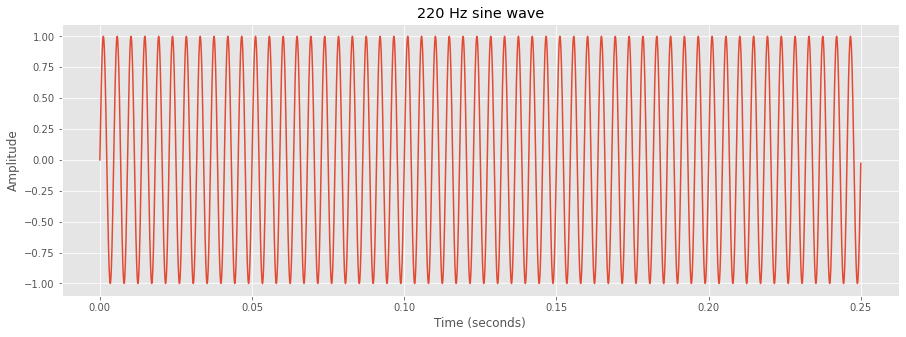

In [7]:
# Configure the sine wave plot
plt.figure(figsize=[15, 5])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'{frequency} Hz sine wave')

# Only plot 1/4 of the data (0.25 seconds)
time_max = sample_rate // 4
plt.plot(time_samples[:time_max], sine_wave[:time_max])

In [8]:
# Generate audio from sine wave data
Audio(sine_wave, rate=sample_rate)

**Question**: Would a 440 Hz sine wave have a higher or lower pitch than the 220 Hz sine wave?

### Audification of CO2 concentration data
We need to modify our data in order to create an audification. First, our data has a sample rate of 12 samples per year. That sample rate is approximately 0.0000004 Hz, and based on the lower limit of human hearing (20 Hz), this frequency is well below our ability to hear.

To bring our dataset into an audible frequency range we must speed it up considerably. We will compress the time scale of our data to a sample rate of 3000 Hz (the lowest sample rate at which we can playback audio with the IPython Audio tool). This equates to a frequency increase of about 10^10.

In [9]:
# Set our sample rate at 3000 Hz
data_sample_rate = 3000

# Generate a series of time samples at a rate of 'dataSampleRate' Hz over 1 second
data_time_samples = np.linspace(0, 1, data_sample_rate)

In [10]:
# Use a linear interpolation to fill NaN values–the audio player WILL NOT WORK
# with data that contains any NaN values
co2_int = co2["CO2ppm"].interpolate()

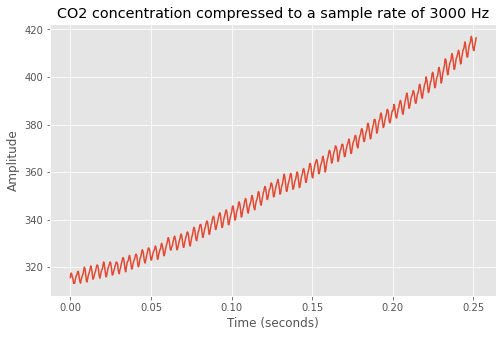

In [11]:
# Configure the plot
plt.figure(figsize=[8, 5])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('CO2 concentration compressed to a sample rate of 3000 Hz')

# Plot the time compress waveform of CO2 concentration data
plt.plot(data_time_samples[:len(co2_int)], co2_int)

In [12]:
# The sample rate of our data is approximately 0.0000004 Hz (12 samples / year),
# we speed it up about 10^10 times (3000 Hz)
Audio(co2_int, rate=data_sample_rate)

**Question:** Why is our audification so short?

### Audification of normalized CO2 concentration data
Even when resampling our dataset at a higher frequency, we still don't really get a useful audio representation of our waveform. We need to modify our dataset even further to establish a central value about which we can measure displacement. To do this we will normalize our dataset by removing the longterm trend from the data (i.e., subtracting the seasonally adjusted CO2 concentration values from the true CO2 concentration values)

In [13]:
# Remove the longterm trend of increasing CO2 concentration
co2["fit_removed"] = (co2["CO2ppm"] - co2["season_adj"])

In [14]:
# Use a linear interpolation to fill NaN values–the audio player WILL NOT WORK
# with data that contains any NaN values
co2_fit_int = co2["fit_removed"].interpolate()

# Print the data
co2_fit_int

date
1958-03-17    1.27
1958-04-17    2.30
1958-05-17    2.81
1958-06-17    1.74
1958-07-17    0.67
              ... 
2020-10-17   -3.63
2020-11-17   -2.27
2020-12-17   -0.93
2021-01-17    0.05
2021-02-17    0.76
Name: fit_removed, Length: 756, dtype: float64

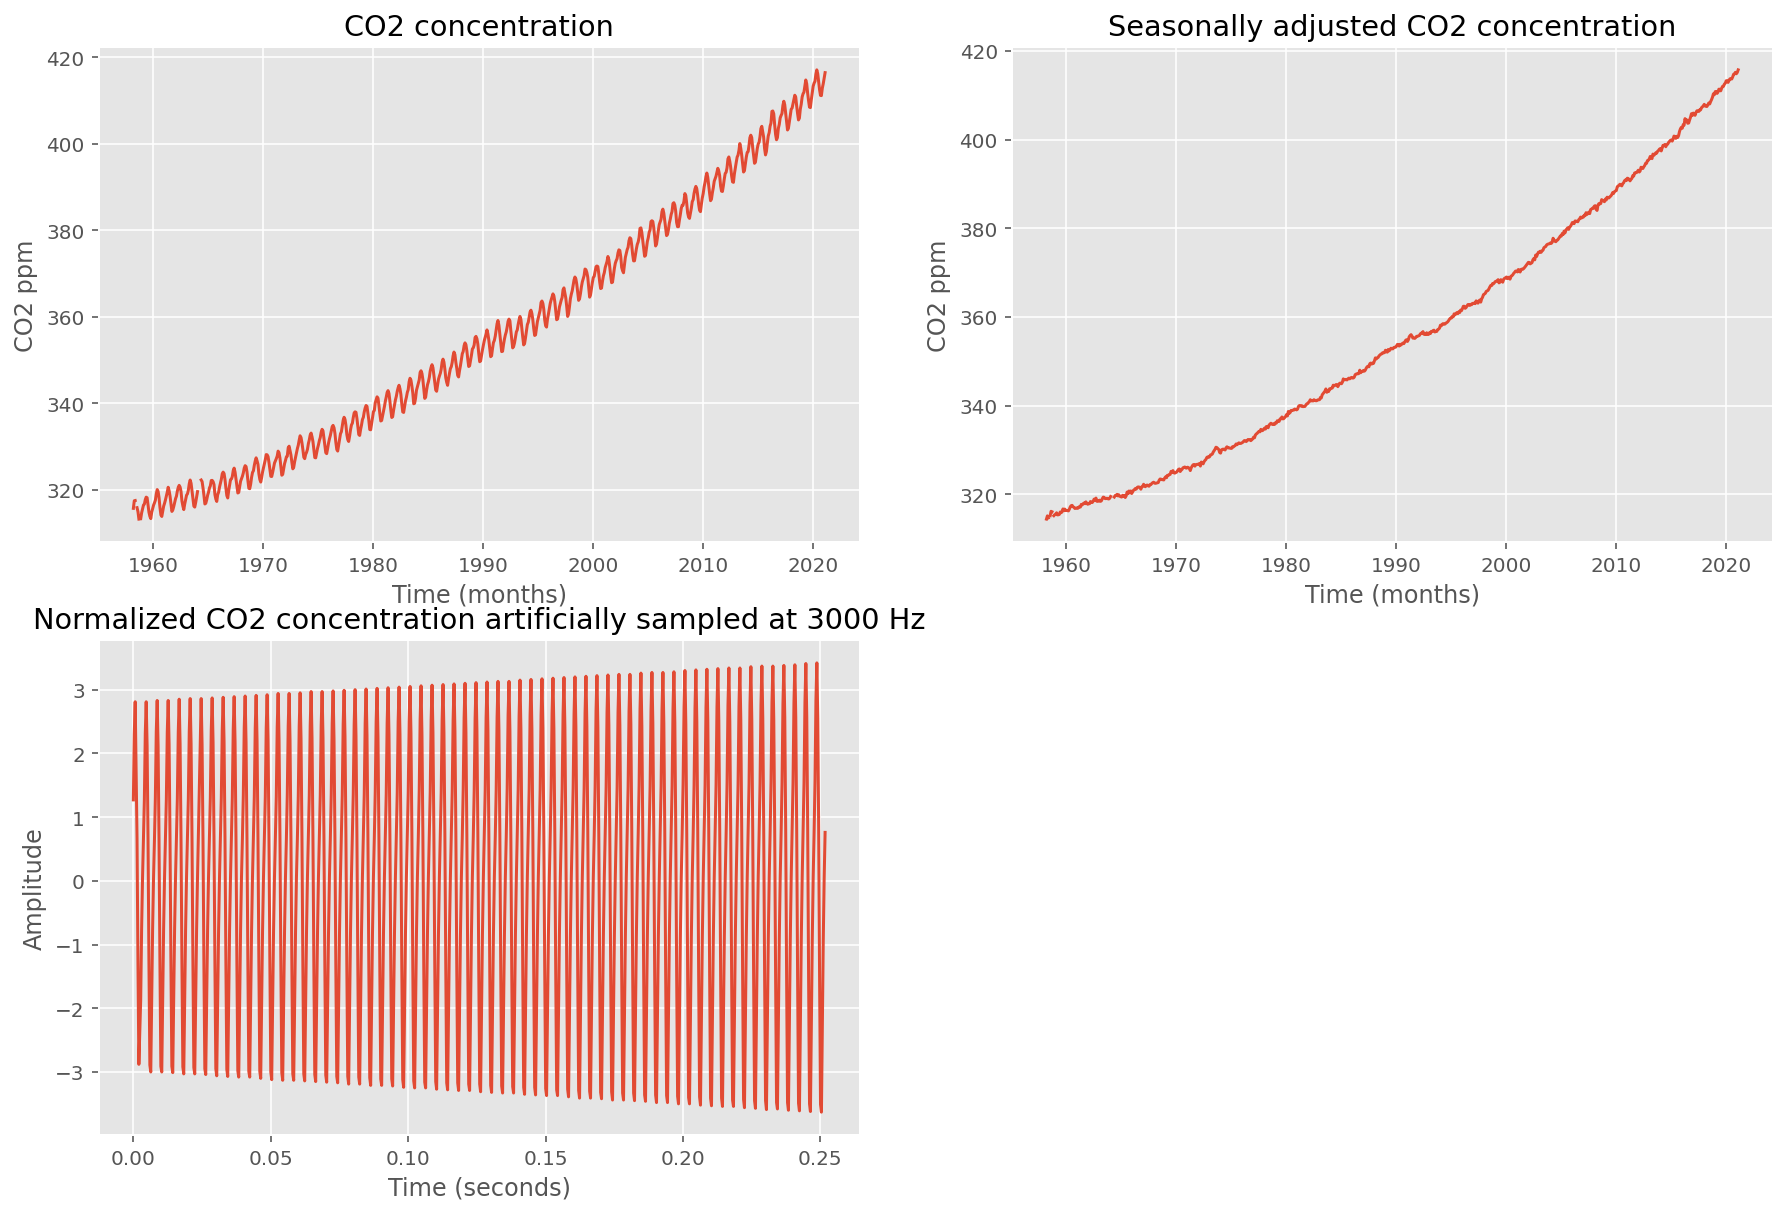

In [15]:
# Plot CO2 concentration data
plt.figure(figsize=[15, 10])
plt.subplot(2, 2, 1)
plt.xlabel('Time (months)')
plt.ylabel('CO2 ppm')
plt.title('CO2 concentration')
plt.plot(co2["CO2ppm"])

# Plot seasonally adjusted CO2 concentration data
plt.subplot(2, 2, 2)
plt.xlabel('Time (months)')
plt.ylabel('CO2 ppm')
plt.title('Seasonally adjusted CO2 concentration')
plt.plot(co2["season_adj"])

# Plot normalized CO2 concentration data over 3000 Hz sample frequency
plt.subplot(2, 2, 3)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Normalized CO2 concentration artificially sampled at 3000 Hz')
plt.plot(data_time_samples[:len(co2_fit_int)], co2_fit_int)

In [16]:
# The sample rate of our data is approximately 0.0000004 Hz (12 samples / year),
# we speed it up about 10^10 times (3000 Hz)
Audio(co2_fit_int, rate=data_sample_rate)

**Question:** Does this audification provide you with any insight into the data or help you pick out any discernable patterns?

## Parameter mapping

Parameter mapping is the process of mapping data to properties of sound. As previously mentioned, these properties can include pitch (frequency), amplitude (loudness), tempo (beat speed), and timbre (quality). The spatial position of sound (for example, panning audio to the left or right channel in a stereo mix) can also be used as a mapping property.
 
As opposed to audification, mapping data to sound properties provides more options and opportunities to represent the features of a dataset.

In this demonstration we will only explore using variations in pitch, tempo, and timbre to represent monthly atmospheric CO2 values.

### Subsample CO2 concentration data for sonification
We will subsample our data to create a smaller dataset that will be appropriate for generating shorter demo sonifications. Additionally, due to some constraints with audio playback in Google Colab we have to create audio files of our sonifications and then load them into our notebook for playback. In this case, smaller files are preferable for shorter load times.

In [17]:
# Create a subsample of the CO2 data from the year 2000 to present (co2_modern)
co2_modern = co2[co2["year"] >= 2000]

# Print the data
co2_modern

year  month  CO2ppm  season_adj  fit_removed
date                                                    
2000-01-17  2000      1  369.05      369.00         0.05
2000-02-17  2000      2  369.37      368.65         0.72
2000-03-17  2000      3  370.42      368.94         1.48
2000-04-17  2000      4  371.57      368.90         2.67
2000-05-17  2000      5  371.74      368.52         3.22
...          ...    ...     ...         ...          ...
2020-10-17  2020     10  411.15      414.78        -3.63
2020-11-17  2020     11  412.88      415.15        -2.27
2020-12-17  2020     12  413.89      414.82        -0.93
2021-01-17  2021      1  415.16      415.11         0.05
2021-02-17  2021      2  416.46      415.70         0.76

[254 rows x 5 columns]

In [18]:
# We are only going to be working with the measured CO2 concentration values
# moving forward, so we will store it in a variable (co2_ppm)
co2_ppm = co2_modern["CO2ppm"]

# Print the data
co2_ppm

date
2000-01-17    369.05
2000-02-17    369.37
2000-03-17    370.42
2000-04-17    371.57
2000-05-17    371.74
               ...  
2020-10-17    411.15
2020-11-17    412.88
2020-12-17    413.89
2021-01-17    415.16
2021-02-17    416.46
Name: CO2ppm, Length: 254, dtype: float64

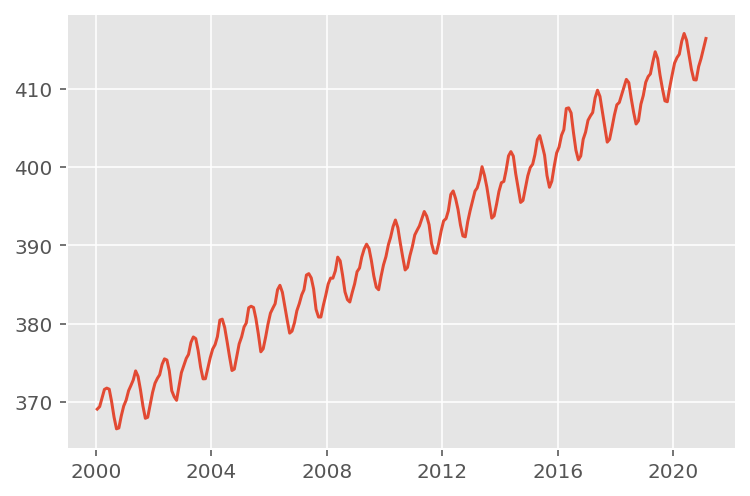

In [19]:
# Plot the subsampled CO2 concentration data
plt.plot(co2_ppm)

In [20]:
# Check out some basic statistics of the subsampled data
co2_ppm.describe()

count    254.000000
mean     390.689134
std       13.727872
min      366.530000
25%      379.145000
50%      389.955000
75%      401.947500
max      417.100000
Name: CO2ppm, dtype: float64

**Question:** Given the values of the descriptive statistics, could we directly use the CO2 concentration data as frequencies (in Hz) in a sonification?

### Functions for generating audio streams and creating audio files

The function `create_audio_stream` creates a music21 audio stream that is playable in local Jupyter notebook using the call `[stream_name].show('midi')`. This functionality is not available in Google Colab, so we must also create an audio file for playback using the function `create_audio_file`.

`create_audio_stream` takes three arguments:
- `notes` - a series of music21 Note objects
- `bpm` - beats per minute, or the speed of the sonification (default value is 120, each note is treated as a 16th note and four notes constitute one beat)
- `instrument_name` - the name of a synthesized instrument to play the notes (default value is "Piano"). A list of instrument names is available in the [music21 documentation](http://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html#module-music21.instrument)

These three arguments provide the data mappings to frequency (the `notes` argument), tempo (the `bpm` argument), and timbre (the `instrument_name` argument).

In [21]:
def create_audio_stream(notes, bpm=120, instrument_name='Piano'):
    """
    Creates and returns a new stream of notes using the music21 Stream class
    given a series of notes, beats per minute (bpm), and an instrument name
    (instrumentName). For a list of valid instrument names see the music21
    Instrument module documentation https://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html
    """
    # Create a new music21 stream object to add notes to
    new_stream = stream.Stream()

    # Set the tempo string of the stream
    new_stream.append(tempo.MetronomeMark(number=bpm))

    # Set the instrument to play the stream notes
    new_stream.append(getattr(instrument, instrument_name)())

    # Iterate over the notes provided in the series
    for this_note in notes:
        # Append the note to the new stream
        new_stream.append(this_note)
        # Set the duration of the note as a sixteenth note (0.25 of quarter note)
        this_note.duration.quarterLength = 0.25
    # Return a music21 stream object
    return new_stream

In [22]:
def create_audio_file(stream, file_name):
    """
    Create an audio file using the given music21 stream and the given file_name.
    It writes a MIDI file using music21 and then uses the newly written MIDI file
    to create the specified audio file using FluidSynth midi to audio conversion
    """
    # Use the music21 stream object write function to create a MIDI file
    stream.write('midi', file_name.split('.')[0] + '.mid')

    # Use the FluidSynth module to call the sound font and convert the newly 
    # created MIDI file to the specified file_name using the midi_to_audio function
    FluidSynth('font.sf2').midi_to_audio(file_name.split('.')[0] + '.mid', file_name)

### Parameter mapping using CO2 concentration data values as frequency (pitch)

In this demonstration we will use a function that directly maps a numeric value to a frequency and the corresponding scientific pitch notation value.

For example, a data value of 440 would be interpreted as the frequency 440 Hz. This frequency would then be converted to scientific pitch notation as the pitch A4 (A in octave 4).

Moving forward we will be thinking of frequency in terms of Hz and scientific pitch notation. It might be helpful to reference this [table of piano key pitches and frequencies](https://en.wikipedia.org/wiki/Piano_key_frequencies#List).

We will use the defined function `translate_value_to_pitch` to translate data values as frequency to pitch. This function takes one argument:

- `value_as_frequency` - a data value interpreted as a frequency

In [23]:
def translate_value_to_pitch(value_as_frequency):
    """
    Translate a raw data value as frequency to a corresponding
    pitch. It returns the pitch of the provided frequency value if the value
    is greater than zero. If the value is less than zero it returns a rest (i.e., 
    silence).
    """
    # Test if the frequency value is greater than zero
    if (value_as_frequency > 0):
        # Create a music21 Note object
        converted_note = note.Note()
        # Set the pitch of the Note object based on the supplied frequency value
        converted_note.pitch.frequency = value_as_frequency
        # Return the Note object with the assigned pitch
        return converted_note
    # Set the Note to a Rest value (silence)
    converted_note = note.Rest()
    # Return the Note object with the assigned pitch
    return converted_note

In [24]:
# Test the translate_value_to_pitch function
test_note = translate_value_to_pitch(440)

The `translateValueToPitch` function has returned a [music21 Note object](http://web.mit.edu/music21/doc/moduleReference/moduleNote.html#module-music21.note). A Note object has many properties. For this workshop the most important properties are the note name and pitch frequency. We can get a full desciptive name by calling the property `fullName` on a Note object. We can get the frequency of a note by callinf the property `pitch.frequency` on a Note object.

In [25]:
# Print out full note name information (fullName)
test_note.fullName

'A in octave 4 Quarter Note'

In [26]:
# Print out the frequency information using "pitch.frequency" (test_note)
test_note.pitch.frequency

440.0

In [27]:
# Map CO2 concentration values directly to pitch
raw_pitch = co2_ppm.apply(translate_value_to_pitch)

#Print the data
raw_pitch

date
2000-01-17    <music21.note.Note F#>
2000-02-17    <music21.note.Note F#>
2000-03-17    <music21.note.Note F#>
2000-04-17    <music21.note.Note F#>
2000-05-17    <music21.note.Note F#>
                       ...          
2020-10-17    <music21.note.Note G#>
2020-11-17    <music21.note.Note G#>
2020-12-17    <music21.note.Note G#>
2021-01-17    <music21.note.Note G#>
2021-02-17    <music21.note.Note G#>
Name: CO2ppm, Length: 254, dtype: object

In [28]:
# Create an audio stream of the raw_pitch values using the create_audio_stream
# function
# Pass in the series of notes (raw_pitch), a tempo in bpm, and an instrument name
# from the list located in the right-hand column of this music21 documentation
# page: https://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html
raw_pitch_stream = create_audio_stream(raw_pitch, 120, 'Xylophone')

# If running on a local machine, uncomment the line below to play the MIDI data
# in the Jupyter notebook without having to create a file
# raw_pitch_stream.show('midi')

In the next cell we are creating an audio file from the music21 stream we created. We will create a FLAC audio file, but it is also possible to create other standard audio file formats such as mp3, mp4, and wave files by changing the file extension. When running this notebook in Colab I found that FLAC audio files tended to load faster with than other file types when using the Audio tool. 

In [29]:
# Create an audio file from the raw_pitch_stream
create_audio_file(raw_pitch_stream, 'raw_pitch.flac')

# Load the newly created audio file for playback
Audio('raw_pitch.flac')

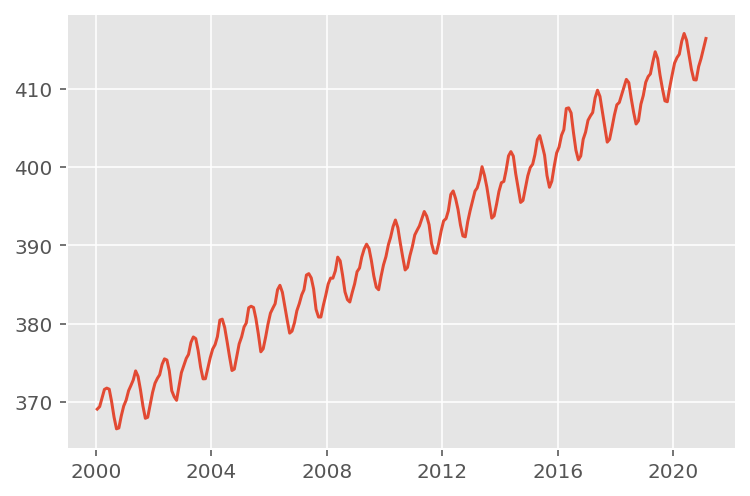

In [30]:
# Plot the data for visual reference
plt.plot(co2_ppm)

#### Activity: Sonify seasonally adjusted CO2 concentrations using `translate_value_to_pitch`

Create a sonification of the seasonally adjusted CO2 concentration data from the `co2_modern` dataset using the `translate_value_to_pitch` method.

In [31]:
# Store the seasonally adjusted concentration data from "co2_modern" in a variable
co2_adj_ppm = co2_modern['season_adj']

# Use the apply() method to call translate_value_to_pitch on each row of the
# seasonally adjusted concentration data
co2_adj_raw_pitch = co2_adj_ppm.apply(translate_value_to_pitch)

# Create the audio stream from the pitch data
co2_adj_raw_pitch_stream = create_audio_stream(co2_adj_raw_pitch, 120)

# Create the audio file from the audio stream
create_audio_file(co2_adj_raw_pitch_stream, 'co2_adj_raw_pitch.flac')

# Load the audio file for playback
Audio('co2_adj_raw_pitch.flac')

Output hidden; open in https://colab.research.google.com to view.

**Question:** Are there any shortcomings with the method we used to create this sonification?

### Sonification using values mapped to linear pitch range
In this demonstration we will use a function that maps a data value from the dataset range (dataMin - dataMax) to the pitch range of a standard 88 key piano (~27 Hz – ~4186 Hz).

We will use the defined function `map_value_to_pitch_range` to map data values from the data domain to a pitch range. This function takes two arguments:
- `data_value` - the data value to be mapped to the new pitch range
- `data_min_max` - a list containing the min and max of the dataset ([min, max])

In [32]:
def map_value_to_pitch_range(data_value, data_min_max):
    """
    Map a data value from the dataset domain (data min - data max)
    to the frequency range of a standard 88 key piano (~16 Hz - ~4186 Hz). It
    returns a music21 Note object with the pitch of the data value mapped to the
    frequency range.
    """
    # Create the music21 Note object
    converted_note = note.Note()

    # Set the data range using supplied min and max
    data_range = data_min_max[1] - data_min_max[0]

    # Frequency of the lowest note on a standard 88 key piano
    MIN_HZ = 27.50
    # Frequency of the highest note on a standard 88 key piano
    MAX_HZ = 4186.01

    # Set the pitch of each Note object mapping from the data range to the
    # frequency range of a standard 88 key piano
    converted_note.pitch.frequency = (
        ((data_value - data_min_max[0]) * (MAX_HZ - MIN_HZ)) / data_range
    ) + MIN_HZ
    return converted_note

In [33]:
# Test the map_value_to_pitch_range function
map_value_to_pitch_range(50, [1, 100]).pitch.frequency

2085.752433828361

In [34]:
# Calculate the minimum and maximum values of the CO2 concentration data
co2_range = co2_ppm.agg(['min', 'max'])

# Convert values to pitch range
pitch_range = co2_ppm.apply(
  lambda x: map_value_to_pitch_range(x, [co2_range['min'], co2_range['max']])
)

In [35]:
# Create an audio stream of the pitch_range values using the create_audio_stream
# function
# Pass in the series of notes (pitch_range), a tempo in bpm, and an instrument name
# from the list located in the right-hand column of this music21 documentation
# page: https://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html
pitch_range_stream = create_audio_stream(pitch_range, instrument_name='Glockenspiel')

# If running on a local machine, uncomment the line below to play the MIDI data
# in the Jupyter notebook without having to create a file
# pitch_range_stream.show('midi')

In [36]:
# Create an audio file from the pitch_range_stream
create_audio_file(pitch_range_stream, 'pitch_range.flac')

# Load the newly created audio file for playback
Audio('pitch_range.flac')

Output hidden; open in https://colab.research.google.com to view.

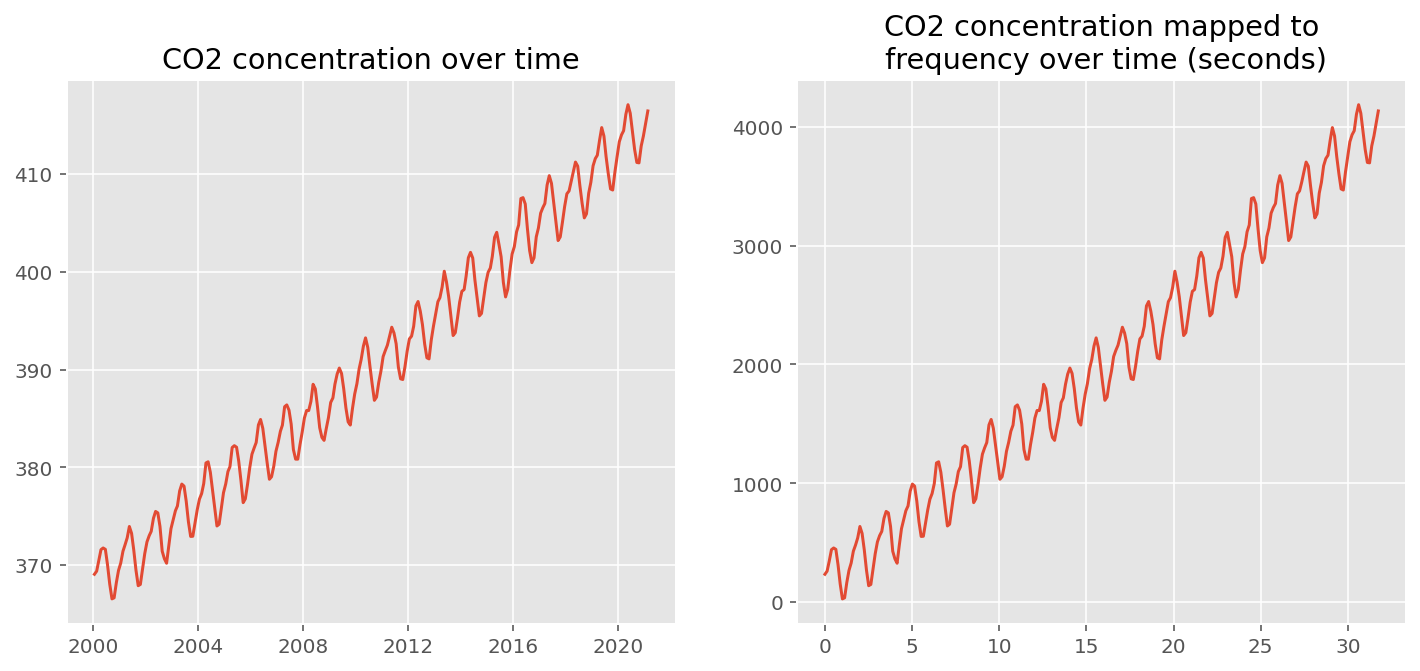

In [37]:
# Plot the actual concentration data and the mapped frequency data for visual reference
plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
plt.title('CO2 concentration over time')
plt.plot(co2_ppm)

plt.subplot(1, 2, 2)
plt.title('CO2 concentration mapped to\n frequency over time (seconds)')
# Create the time scale for the audio file using the bpm
time_scale = np.linspace(0, (len(pitch_range) / 4) / 120 * 60, len(pitch_range))
plt.plot(time_scale, pitch_range.apply(lambda x: x.pitch.frequency))

#### Activity: Sonify seasonally adjusted CO2 concentrations using `map_value_to_pitch_range`

Create a sonification of the seasonally adjusted CO2 concentration data using the `map_value_to_pitch_range` method.

In [38]:
# Calculate the min and max values of the seasonally adjusted C02 concentration
# data
co2_adj_range = co2_adj_ppm.agg(['min', 'max'])

# Use the apply() method to call map_value_to_pitch_range on each row of the
# seasonally adjusted concentration data
co2_adj_pitch_range = co2_adj_ppm.apply(
    lambda x: map_value_to_pitch_range(x, [co2_adj_range['min'],
                                           co2_adj_range['max']]))

# Create the audio stream from the pitch data
co2_adj_pitch_range_stream = create_audio_stream(co2_adj_pitch_range,
                                               instrument_name='Trumpet')

# Create the audio file from the audio stream
create_audio_file(co2_adj_pitch_range_stream, 'co2_adj_pitch_range.flac')

# Load the audio file for playback
Audio('co2_adj_pitch_range.flac')

Output hidden; open in https://colab.research.google.com to view.

### Sonification using values mapped to an exponential pitch range
The frequency ranges between pitches are not linear. For example, the frequency of note A4 is 440 Hz. To get to the next octave of this note we must double the frequency of A4, giving A5 as 880 Hz (i.e., A6 = 1760, A3 = 220, and so on). In order to map our values to an appropriate pitch scale, we can apply a log base two transform to pitch range. This makes it easier to discern pitches at lower frequencies and produces a more natural and pleasing sound.

In this demonstration we will use a function that maps a data value from the dataset range (dataMin - dataMax) to the frequency range of a standard 88 key piano (\~27 Hz – \~4186 Hz) over an exponential scale.

We will use the defined function `map_value_to_pitch_range_exp_scale` to map data values from the data domain to a log scale pitch range. This function takes two arguments:
- `data_value` - the data value to be mapped to the new pitch range
- `data_min_max` - a list containing the min and max of the dataset ([min, max])

In [39]:
# https://stackoverflow.com/questions/19472747/convert-linear-scale-to-logarithmic
#           x - x0
# log(y) = ------- * (log(y1) - log(y0)) + log(y0)
#          x1 - x0
def map_value_to_pitch_range_exp_scale(data_value, data_min_max):
    """
    Map a data value from the dataset domain (data min - data
    max) to the log2 frequency range of a standard 88 key piano (~16 Hz – ~4186
    Hz). It returns a music21 Note object with the pitch of the mapped frequency
    value.
    """
    # Create the music21 Note object
    converted_note = note.Note()

    # Set the data range using supplied min and max
    data_range = data_min_max[1] - data_min_max[0]

    # Frequency of the lowest note on a standard 88 key piano
    MIN_HZ = 27.50
    # Frequency of the highest note on a standard 88 key piano
    MAX_HZ = 4186.01

    # Set the pitch of each Note object, mapping from the data range to a
    # log base 2 frequency range of a standard 88 key piano
    converted_note.pitch.frequency = np.exp2(
        (data_value - data_min_max[0]) / data_range *
        (np.log2(MAX_HZ) - np.log2(MIN_HZ)) +
        np.log2(MIN_HZ)
    )
    return converted_note

In [40]:
# Test the map_value_to_pitch_range function
map_value_to_pitch_range_exp_scale(0, [-50, 50]).pitch.frequency

339.2864207856489

In [41]:
# Convert values to pitch range
pitch_range_exp = co2_ppm.apply(lambda x:
  map_value_to_pitch_range_exp_scale(x, [co2_range['min'], co2_range['max']])
)

In [42]:
# Create an audio stream of the pitch_range_exp values using the createAudioStream
# function. Pass in the series of notes (pitch_range_exp), a tempo in bpm, and an
# instrument name from the list located in the right-hand column of this music21
# documentation page: https://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html
pitch_range_exp_stream = create_audio_stream(pitch_range_exp, 100, 'Xylophone')

# If running on a local machine, uncomment the line below to play the MIDI data
# in the Jupyter notebook without having to create a file
# pitch_range_exp_stream.show('midi')

In [45]:
# Create an audio file from the pitch_range_exp_stream
create_audio_file(pitch_range_exp_stream, 'pitch_range_exp.flac')

# Load the newly created audio file for playback
Audio('pitch_range_exp.flac')

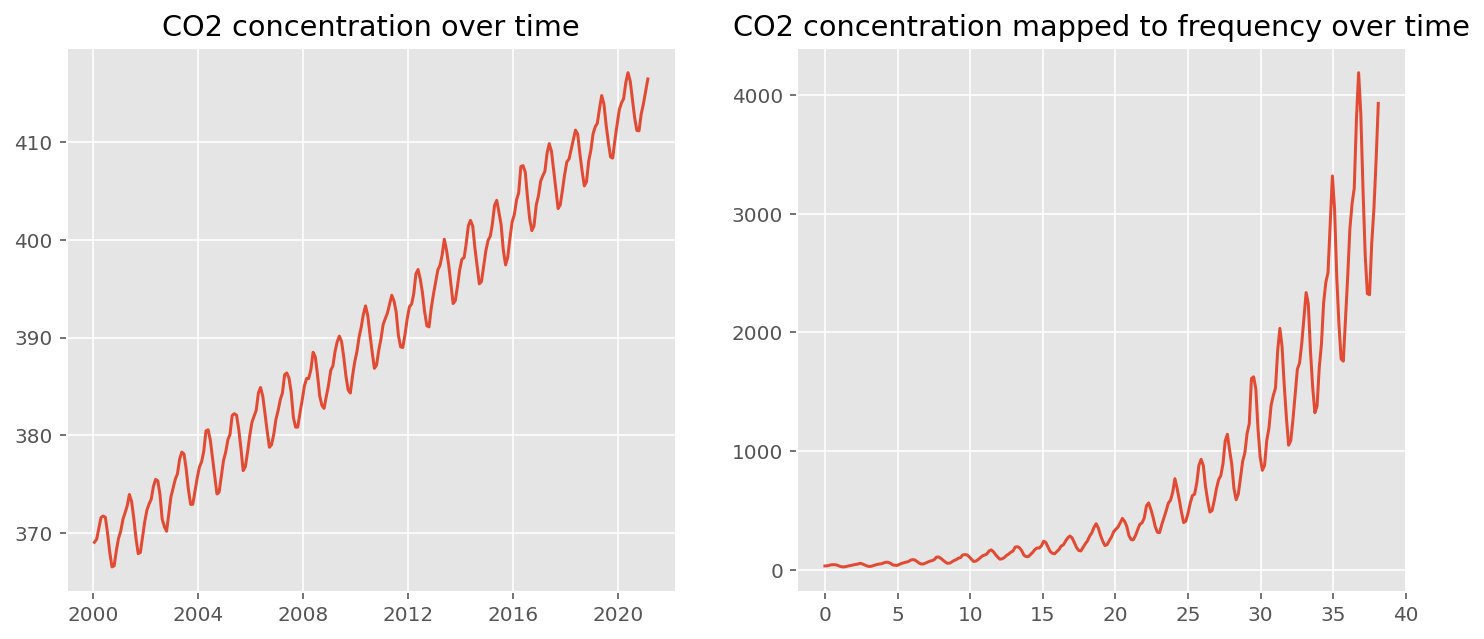

In [46]:
# Plot the actual concentration data and the mapped frequency data for visual reference
plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
plt.title('CO2 concentration over time')
plt.plot(co2_ppm)

plt.subplot(1, 2, 2)
plt.title('CO2 concentration mapped to frequency over time')
# Calculate the time scale for the audio we generated using the bpm
time_scale = np.linspace(0, len(pitch_range) / 4 / 100 * 60, len(pitch_range))

plt.plot(time_scale, pitch_range_exp.apply(lambda x: x.pitch.frequency))

#### Activity: Sonify seasonally adjusted CO2 concentrations using `map_value_to_pitch_range_exp_scale`

Create a sonification of the seasonally adjusted CO2 concentration data using the `map_value_to_pitch_range_exp_scale` method.

In [47]:
# Use the apply() method to call map_value_to_pitch_range on each row of the
# seasonally adjusted concentration data
co2_adj_exp = co2_adj_ppm.apply(
    lambda x: map_value_to_pitch_range_exp_scale(x, [co2_adj_range['min'],
                                                     co2_adj_range['max']]))

# Create the audio stream from the pitch data
co2_adj_exp_stream = create_audio_stream(co2_adj_exp, 100, 'MezzoSoprano')

# Create the audio file from the audio stream
create_audio_file(co2_adj_exp_stream, 'co2_adj_exp.flac')

# Load the audio file for playback
Audio('co2_adj_exp.flac')

Output hidden; open in https://colab.research.google.com to view.

### Sonification using values mapped to a musical scale

In this demonstration we will use a function that maps a data value from the dataset range (dataMin - dataMax) to a specified [musical scale](https://en.wikipedia.org/wiki/Scale_(music)) (i.e., an ordered group of pitches) with the given provided starting note (i.e., the tonic) and an octave range (i.e., the number of notes over which to map your data).

Using a musical scale provides us with some options to make our sonification more "musical". Previously we were mapping values to frequencies and pitches without consideration for ordering of notes. Predefined musical scales can evoke culturally influenced emotions that can give our sonification an aesthetic feeling. For example, major scales are often interpreted as happy, while minor scales are interpreted as sad.

We will use the defined function `map_value_to_scale` to map data values from the data domain to a musical scale. This function takes five arguments:
- `data_value` - the data value to be mapped to the new pitch range
- `data_min_max` - a list containing the min and max of the dataset ([min, max])
- `tonic` - a string containing a valid scientific pitch notation for the first note of the scale
- `scale_name` - a string containing a valid scale subclass name from the music21 scale class (default value is "MajorScale"). A list of scale names is available in the [music21 documentation](http://web.mit.edu/music21/doc/moduleReference/moduleScale.html#module-music21.scale)
- `octave_range` - a list containing the min and max octave numbers over which to map the pitches (default value is [3, 5])

In [48]:
def map_value_to_scale(data_value, data_min_max, tonic='c',
                       scale_name='MajorScale', octave_range=[3, 5]):
    """
    Map a data value from the dataset domain (data min - data max)
    to a musical scale with a provided tonic note over a provided octave range. It
    returns a music21 Note object with the pitch of the mapped data value. 
    """
    # Create the music21 Note object
    converted_note = note.Note()

    # Set the scale using the supplied tonic value
    this_scale = getattr(scale, scale_name)(tonic)
    # Get the pitches of the scale based on the octave range
    scale_pitches = this_scale.getPitches(
        tonic + str(octave_range[0]),
        tonic + str(octave_range[1]))
    
    # Get the data range using supplied min and max 
    dataRange = data_min_max[1] - data_min_max[0]

    # Get the position of the note on the scale given the range of the scale
    note_position = round(
        ((data_value - data_min_max[0]) * (len(scale_pitches) - 1)) / dataRange)
    # Set the pitch of the note
    converted_note.pitch = scale_pitches[note_position]
    return converted_note

The C major scale has a base note (tonic) of C and consists of the notes: C, D, E, F, G, A, B.

In [49]:
# Test the map_value_to_scale function
c_major_note = map_value_to_scale(0, [0, 7], octave_range=[3,4])
c_major_note.fullName

'C in octave 3 Quarter Note'

In [50]:
# Convert values to musical scale
musical_notes = co2_ppm.apply(lambda x:
  map_value_to_scale(
    x,
    [co2_range['min'], co2_range['max']],
    tonic='d',
    scale_name='MinorScale',
    octave_range=[2, 7]
  )
)

In [51]:
# Create an audio stream of the musical_notes values using the createAudioStream
# function. Pass in the series of notes (musical_notes), a tempo in bpm, and an
# instrument name from the list located in the right-hand column of this music21
# documentation page: https://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html
musical_notes_stream = create_audio_stream(musical_notes, 100, 'Harpsichord')

# If running on a local machine, uncomment the line below to play the MIDI data
# in the Jupyter notebook without having to create a file
# musical_notes_stream.show('midi')

In [52]:
# Create an audio file from the musical_notes_stream
create_audio_file(musical_notes_stream, 'musical_notes.flac')

# Load the newly created audio file for playback
Audio('musical_notes.flac')

Output hidden; open in https://colab.research.google.com to view.

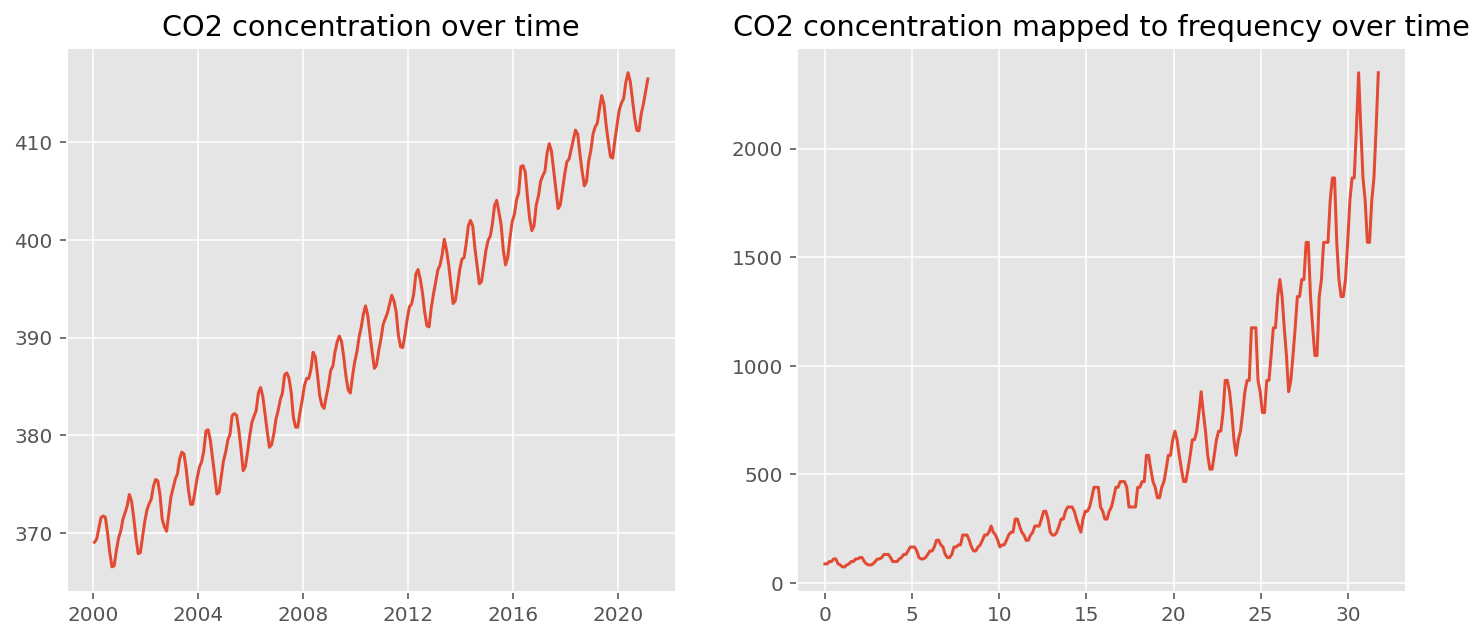

In [53]:
# Plot the actual concentration data and the mapped frequency data for visual reference
plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
plt.title('CO2 concentration over time')
plt.plot(co2_ppm)

plt.subplot(1, 2, 2)
plt.title('CO2 concentration mapped to frequency over time')
# Create the time scale for the audio file using the bpm
time_scale = np.linspace(0, (len(pitch_range) / 4) / 120 * 60, len(pitch_range))

plt.plot(time_scale, musical_notes.apply(lambda x: x.pitch.frequency))

#### Activity: Sonify seasonally adjusted CO2 concentrations using `map_value_to_scale`

Create a sonification of the seasonally adjusted CO2 concentration data using the `map_value_to_scale` method.

In [54]:
# Use the apply() method to call map_value_to_scale on each row of the
# seasonally adjusted concentration data
co2_adj_notes = co2_adj_ppm.apply(
    lambda x: map_value_to_scale(x,
                                 [co2_adj_range['min'], co2_adj_range['max']],
                                 'g',
                                 'DiatonicScale',
                                 [2,6])
)

# Create the audio stream from the pitch data
co2_adj_notes_stream = create_audio_stream(co2_adj_notes, 140, 'ChurchBells')

# Create the audio file from the audio stream
create_audio_file(co2_adj_notes_stream, 'co2_adj_notes.flac')

# Load the audio file for playback
Audio('co2_adj_notes.flac')

Output hidden; open in https://colab.research.google.com to view.

### Sonification playground

Use the cells below to generate your own sonifications of the CO2 concentration data using the provided functions.

You can the call the following functions on a Pandas Series using the `apply()` function:

- `translate_value_to_pitch(value_as_frequency)`

- `map_value_to_pitch_range(data, data_min_max)`

- `map_value_to_pitch_range_exp_scale(data, data_min_max)`

- `map_value_to_scale(data, data_min_max, tonic="c", scale_name="MajorScale",
  octave_range=[3, 5])`

For example, to create a sonification of the modern CO2 data you could do the following:

1. Map the data to a log scale pitch range to return a series of music21 Note objects
```python
pitch_range = co2_modern['season_adj'].apply(lambda x:
      map_value_to_pitch_range_exp_scale(x, [co2_range['min'], co2_range['max']])
)
```

1. Create a music21 stream of the Note objects at 100 bpm using a Guitar sound
```python
notes_stream = create_audio_stream(pitch_range, 100, 'Guitar')
```

1. Create an audio file from the stream and play it back
```python
create_audio_file(notes_stream, 'demo_notes.flac')
Audio('demo_notes.flac')
```

## Other resources

### Unfilled version of this notebook

[Data Sonification with Python starter notebook](https://colab.research.google.com/github/ncsu-libraries-data-vis/data-sonification-with-python/blob/main/data-sonification-with-python.ipynb) - a version of this notebook without any exercise code filled in. Use this version of the notebook to practice concepts and coding or to lead a workshop.

### Sonification development tools and applications

- [Sonic Pi](https://sonic-pi.net/) - a code-based music creation and performance tool based on the Ruby programming language

- [p5.js](https://p5js.org/) - a JavaScript library for creative coding that includes a library for interfacing with web-based audio.

- [Web audio API](https://developer.mozilla.org/en-US/docs/Web/API/Web_Audio_API) - base API for controling audio on the web

- [SAS Graphics Accelerator](https://support.sas.com/software/products/graphics-accelerator/samples/index.html) - a free Chrome extension that allows you to sonify data captured from web tables and data from web-based SAS visualization

- [TwoTone](https://app.twotone.io/) - An interactive web application for easily creating sonifications with uploaded data

### Sonification theory and practice

- [The Sonification Handbook](https://sonification.de/handbook/) - an open access textbook published in 2011 providing an introduction to sonification and sonification research and techniques

- [An Overview of Auditory Displays and Sonification](https://sonification.de/) - the website of Thomas Hermann, one of the editors of The Sonification Handbook, providing an overview of sonification

- [DataSonificationBlog](https://www.saralenzi.com/datasonificationblog) - blog of Sara Lenzi, sonification researcher

- [Intentionality and design in the data sonification of social issues](https://www.researchgate.net/publication/343692618_Intentionality_and_design_in_the_data_sonification_of_social_issues) - a journal article analyzing the role of intentionality when designing sonifications that communicate social issues to public audiences

- [Thirteen Years of Reflection on Auditory Graphing: Promises, Pitfalls, and Potential New Directions](https://digitalcommons.unl.edu/cgi/viewcontent.cgi?referer=http://playitbyr.org/&httpsredir=1&article=1429&context=psychfacpub) - a 2005 journal article covering sonification methods and discussing the success of these methods

- [Loud Numbers](https://www.loudnumbers.net/) - a data sonification podcast and mailing list



## Credits

This workshop was created by Walt Gurley at the NC State University Libraries.